# Encrypted Face Recognition (EFR) with enVector

In this tutorial, we will demonstrate how to use enVector to securely store and search face templates without revealing sensitive information.

## Risk of being impersonated through face reconstruction

A face template is extracted from individuals and stored in the database.
The template is compared with others in the database for either verification or identification.
However, the template is still privacy-sensitive shown by the recent many studies. 
This is called face template inversion (TI) attack, which reconstructs the original face image from the face template.
Even though these templates look like meaningless vectors, an attacker who steals them could potentially rebuild a person's face or impersonate them elsewhere. 
The figure below shows how original face from the left can be reconstructed to the right.

![Face Template Inversion Attack](./assets/face_reconstruction.png)

That is why we focus on encryption: keeping face templates secure even if when they are being matched.

This EFR tutorial follows the steps below:

1. Administration to enVector server
    1. Load Image Dataset
    2. Extract Face Templates from Images
    2. enVector Initialization
    3. Insert Encrypted Face Templates

2. Encrypted Face Recognition
    1. Get Query Face Template
    2. Encrypted Similarity Search Computation

## Administration to enVector server

In this section, we will store encrypted face templates into enVector server.

In [1]:
import os
import numpy as np
from PIL import Image
import pyenvector as ev
from pyenvector.crypto import Cipher

### Load Image Dataset

We start by pointing the notebook to the directory that contains example face images.

In this example, we used 10 face images from [https://thispersonnotexist.org/](https://thispersonnotexist.org/).
Note that, this dataset is generated by AI, and the source website demonstrates that they grant permission for commercial purposes.

In [ ]:
image_path = os.environ.get("FACE_IMAGE_PATH", "./images")

images = [
    Image.open(os.path.join(image_path, file_path)).convert('RGB')
    for file_path in os.listdir(image_path)
]

### Get Face Templates from Images

This step extracts face templates (face embedding vectors) from every image.

In [4]:
import torch
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1

In [5]:
class FaceEmbeddingModel:
    """
    Face embedding model to extract face templates
    Model: FaceNet based on InceptionResnetV1 pretrained on VGGFace2
    """
    def __init__(self):
        self.dim = 512
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.preprocess = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.model = InceptionResnetV1(pretrained='vggface2').eval().to(self.device)

    def extract(self, image: Image):
        input_image = self.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            embedding = self.model(input_image.to(self.device)).cpu().numpy().flatten()
            assert len(embedding) == self.dim
        embedding = embedding / np.linalg.norm(embedding)
        return embedding

In [6]:
embedding_model = FaceEmbeddingModel()
embeddings = np.array([embedding_model.extract(image) for image in images])
metadata = [f"person_{i+1}" for i in range(len(images))]

### enVector Initialization

Before we can insert ciphertexts into an index, the client must initialize enVector.
This includes enVector server connection setup and cryptographic key generation.
And then, we create the index on the server side to store encrypted face templates.

In [7]:
# envector initialization
ev.init(
    address="localhost:50050",
    key_path="./keys",
    key_id="efr_key",
)

In [8]:
# create index
index = ev.create_index("efr_index", dim=512)

### Insert Encrypted Face Templates

And we encrypt each template and insert them to the enVector index.

In [9]:
# Explicitly encrypt each item (vector) before sending
cipher = Cipher(dim=512, enc_key_path="keys/efr_key/EncKey.json")
enc_vectors = [cipher.encrypt(vector, "item") for vector in embeddings]
enc_vectors[0]

In [10]:
# insert data into index
ids = index.insert(enc_vectors , metadata=metadata)

Insert CipherBlock Bulk: 100%|██████████| 10/10 [00:00<00:00, 44.37it/s]


## Encrypted Similarity Search

Select one face image as a query to extract the face template.
This query template is sent to the enVector server for 1:N identification by encrypted similarity search.

### Get Query Face Template

For example, we reuse the same query image to check whether it matches correctly. 
If you want to test another person, select a different image file for query.

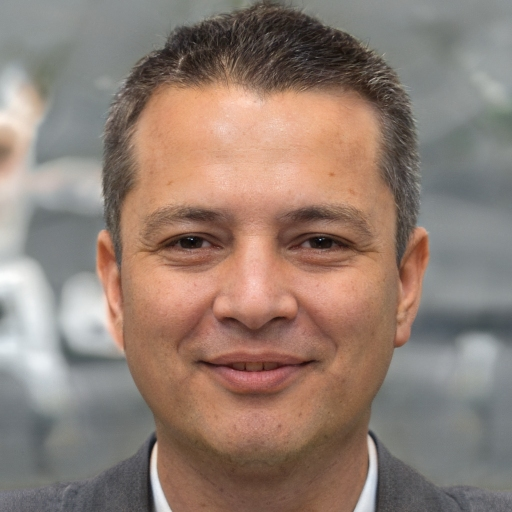

In [11]:
# query
image = images[0]
image

In [12]:
query_embedding = embedding_model.extract(image)

### Encrypted Similarity Search Computation

Match the face template against the database.
enVector performs the similarity computation on encrypted data using fully homomorphic encryption (FHE).
The computation result is sent to the key server to get matching decision by decrypting the result ciphertext safely in a secured environment.

In [13]:
encrypted_scores = index.scoring(query_embedding)[0]
encrypted_scores

### Decrypting the Search Results

The secret key held by client is required to interpret the encrypted similarity scores returned from the server.
Note that, client holds the secret key securely, and it is never shared with the server.

In [15]:
sec_key_path = "keys/efr_key/SecKey.json"
scores = cipher.decrypt_score(encrypted_scores, sec_key_path=sec_key_path)
print(scores)

{'score': [[0.9999898076057434], [0.29114848375320435], [0.13982366025447845], [0.27118316292762756], [0.052340902388095856], [0.031558092683553696], [0.27618372440338135], [0.25925105810165405], [-0.039598047733306885], [0.15539948642253876]], 'shard_idx': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


### Metadata Retrieval

Once a match is found, we pull the associated metadata (such as a user identifier or display name) from the reference dataset. 
This step is optional but it completes the story by showing how an application would translate an encrypted match back into something meaningful for the operator.

In [16]:
topk = index.get_topk_metadata_results(scores, top_k=1, output_fields=["metadata"])
print(topk)

[{'id': 1, 'score': 0.9999898076057434, 'metadata': 'person_1'}]
